<a href="https://colab.research.google.com/github/midiazdi/LSTM-networks/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import multiprocessing
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Datos
# ==============================================================================
datos = pd.read_csv('meatspec.csv')
datos = datos.drop(columns = datos.columns[0])
datos.shape

(215, 101)

In [ ]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    input: Dataframa
    output:
    '''

    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)


    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
display(tidy_corr_matrix(corr_matrix).head(5))

,variable_1,variable_2,r,abs_r
1019,V11,V10,0.999996,0.999996
919,V10,V11,0.999996,0.999996
1021,V11,V12,0.999996,0.999996
1121,V12,V11,0.999996,0.999996
917,V10,V9,0.999996,0.999996


<class 'pandas.core.frame.DataFrame'>


In [ ]:
# División de los datos en train y test
# ==============================================================================
X = datos.iloc[:,:-1]
y = datos.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size= 0.7,
                                                    random_state = 1234,
                                                    shuffle= True)



In [ ]:
# Creación y entrenamiento del modelo
# ==============================================================================
modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train)

LinearRegression()

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()
# Error de test del modelo
# ==============================================================================
rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 3.8396675855870854


#Optimización

In [ ]:
# Entrenamiento modelo de regresión precedido por PCA con escalado
# ==============================================================================
pipe_modelado = make_pipeline(StandardScaler(), PCA(), LinearRegression())
pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])

In [ ]:
pipe_modelado.set_params

<bound method Pipeline.set_params of Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])>

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 3.839667585609795


In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'pca__n_components': [1, 2, 4, 6, 8, 10, 15, 20, 30, 50]}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe_modelado,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = KFold(n_splits=5),
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

#Resultados
#==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(3)

,param_pca__n_components,mean_test_score,std_test_score,mean_train_score,std_train_score
8,30,-2.710551,1.104449,-1.499120,0.071778
5,10,-2.791629,0.416056,-2.448375,0.109985
6,15,-2.842055,0.585350,-2.247184,0.099187


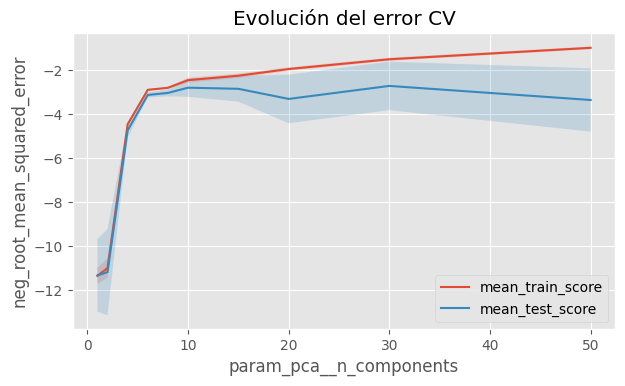

In [ ]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.84), sharey=True)

resultados.plot('param_pca__n_components', 'mean_train_score', ax=ax)
resultados.plot('param_pca__n_components', 'mean_test_score', ax=ax)
ax.fill_between(resultados.param_pca__n_components.astype(np.float), ##linea roja
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados.param_pca__n_components.astype(np.float), #linea azul
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel('neg_root_mean_squared_error');

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'pca__n_components': 30} : -2.7105505991483345 neg_root_mean_squared_error


In [ ]:
# Entrenamiento modelo de regresión precedido por PCA con escalado
# ==============================================================================
pipe_modelado = make_pipeline(StandardScaler(), PCA(n_components=5), LinearRegression())
pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('linearregression', LinearRegression())])

In [ ]:
# Predicciones test
# ==============================================================================
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 3.3593348045226685
